In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc


In [ ]:
pip install catboost xgboost lightgbm optuna shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.6 MB/s eta 0:00:00


In [ ]:
import xgboost as xgb
import catboost as cat
import lightgbm as lgb

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load data
train = pd.read_csv("/Train.csv")
test = pd.read_csv("/Test.csv")
sample_sub = pd.read_csv("/Sample Submission.csv")

In [ ]:
# Quick data overview
print("Train Data Overview:")
print(train.info(), "\n")
print("Test Data Overview:")
print(test.info(), "\n")

Train Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5898 entries, 0 to 5897
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 5898 non-null   int64  
 1   Loan_ID            5898 non-null   object 
 2   Gender             5898 non-null   int64  
 3   Married            5898 non-null   int64  
 4   Dependents         5898 non-null   object 
 5   Education          5898 non-null   int64  
 6   Self_Employed      5898 non-null   int64  
 7   ApplicantIncome    5898 non-null   int64  
 8   CoapplicantIncome  5898 non-null   float64
 9   LoanAmount         5898 non-null   int64  
 10  Loan_Amount_Term   5898 non-null   int64  
 11  Credit_History     5898 non-null   int64  
 12  Property_Area      5898 non-null   int64  
 13  Loan_Status        5898 non-null   int64  
 14  Total_Income       5898 non-null   int64  
dtypes: float64(1), int64(12), object(2)
memory usage: 6

In [ ]:
# Data Cleaning and Preprocessing
# Handle missing values (simple imputation as example)
# Select only numeric columns for median calculation
numeric_columns = train.select_dtypes(include=np.number).columns
train[numeric_columns] = train[numeric_columns].fillna(train[numeric_columns].median())

# Repeat for the test dataset
numeric_columns_test = test.select_dtypes(include=np.number).columns
test[numeric_columns_test] = test[numeric_columns_test].fillna(test[numeric_columns_test].median())

In [ ]:
# Encode categorical variables
train_processed = pd.get_dummies(train, columns=['Dependents'], drop_first=True)
test_processed = pd.get_dummies(test, columns=['Dependents'], drop_first=True)


In [ ]:
# Align train and test datasets
features = [col for col in train_processed.columns if col not in ['ID', 'Loan_Status', 'Loan_ID']]
X = train_processed[features]
y = train_processed['Loan_Status']
test_processed = test_processed[features]

In [ ]:
# Feature Engineering: Create new features
train_processed['TotalIncome'] = train_processed['ApplicantIncome'] + train_processed['CoapplicantIncome']
test_processed['TotalIncome'] = test_processed['ApplicantIncome'] + test_processed['CoapplicantIncome']

# Log transformation for skewed features (e.g., LoanAmount)
train_processed['LoanAmount_log'] = np.log1p(train_processed['LoanAmount'])
test_processed['LoanAmount_log'] = np.log1p(test_processed['LoanAmount'])

# Binning for LoanAmount
train_processed['LoanAmount_bin'] = pd.cut(train_processed['LoanAmount'], bins=[0, 100, 300, 500, 1000], labels=['low', 'medium', 'high', 'very_high'])
test_processed['LoanAmount_bin'] = pd.cut(test_processed['LoanAmount'], bins=[0, 100, 300, 500, 1000], labels=['low', 'medium', 'high', 'very_high'])

# Recreate features list after adding new ones
features = [col for col in train_processed.columns if col not in ['ID', 'Loan_Status', 'Loan_ID']]
X = train_processed[features]
y = train_processed['Loan_Status']
test_processed = test_processed[features]


In [ ]:
# Feature Engineering: Create new features
# ... (your existing feature engineering code) ...

# One-hot encode categorical features before scaling
X = pd.get_dummies(X, columns=['LoanAmount_bin', 'Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area'], drop_first=True)
# Include all your categorical columns here

test_processed = pd.get_dummies(test_processed, columns=['LoanAmount_bin', 'Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area'], drop_first=True)
# Include all your categorical columns here, ensuring they match the training set

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
test_scaled = scaler.transform(test_processed)

In [ ]:
# Train-test split
x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42, stratify=y)

In [ ]:
from sklearn.model_selection import StratifiedKFold

# Cross-validation with Stratified KFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for train_index, val_index in kf.split(X_scaled, y):
    X_train_fold, X_val_fold = X_scaled[train_index], X_scaled[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    model = XGBClassifier(random_state=42)
    model.fit(X_train_fold, y_train_fold)
    preds = model.predict(X_val_fold)
    score = accuracy_score(y_val_fold, preds)
    cv_scores.append(score)

print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Cross-Validation Accuracy:", np.mean(cv_scores))


Cross-Validation Accuracy Scores: [0.8127118644067797, 0.8169491525423729, 0.8177966101694916, 0.81509754028838, 0.818490245971162]
Mean Cross-Validation Accuracy: 0.8162090826756373


In [ ]:
import optuna
from sklearn.metrics import accuracy_score

def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0)
    }
    model = XGBClassifier(**param, random_state=42)
    model.fit(x_train, y_train)
    preds = model.predict(x_test)
    return accuracy_score(y_test, preds)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
print(f"Best hyperparameters: {study.best_params}")


[I 2024-11-22 22:30:15,705] A new study created in memory with name: no-name-7793c8a3-963e-4926-a077-bac72832af22
[I 2024-11-22 22:30:15,936] Trial 0 finished with value: 0.8332203389830508 and parameters: {'n_estimators': 309, 'learning_rate': 0.03699236406774561, 'max_depth': 3, 'subsample': 0.5742178436331334, 'colsample_bytree': 0.666505272397148}. Best is trial 0 with value: 0.8332203389830508.
[I 2024-11-22 22:30:18,752] Trial 1 finished with value: 0.8332203389830508 and parameters: {'n_estimators': 484, 'learning_rate': 0.0101693378235261, 'max_depth': 10, 'subsample': 0.5990503566692852, 'colsample_bytree': 0.6501962056251206}. Best is trial 0 with value: 0.8332203389830508.
[I 2024-11-22 22:30:28,236] Trial 2 finished with value: 0.8135593220338984 and parameters: {'n_estimators': 366, 'learning_rate': 0.03553494053369531, 'max_depth': 11, 'subsample': 0.6991749335952442, 'colsample_bytree': 0.6021220396679888}. Best is trial 0 with value: 0.8332203389830508.
[I 2024-11-22 22

Best hyperparameters: {'n_estimators': 309, 'learning_rate': 0.03699236406774561, 'max_depth': 3, 'subsample': 0.5742178436331334, 'colsample_bytree': 0.666505272397148}


In [ ]:
# Model Evaluation Framework
def evaluate_model(model, x_test, y_test):
    y_pred = model.predict(x_test)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Accuracy Score:", accuracy_score(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

Logistic Regression Results:
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       246
           1       0.83      1.00      0.91      1229

    accuracy                           0.83      1475
   macro avg       0.42      0.50      0.45      1475
weighted avg       0.69      0.83      0.76      1475

Accuracy Score: 0.8332203389830508


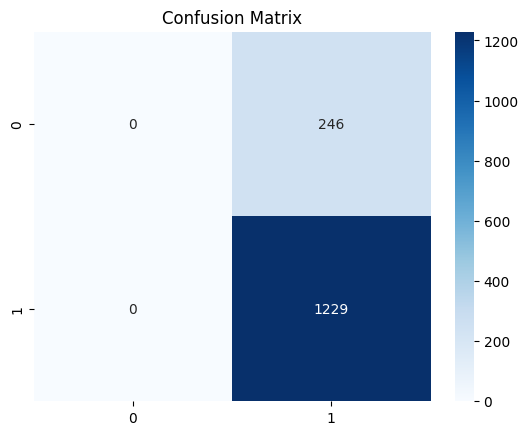

In [ ]:
# Logistic Regression
lr = LogisticRegression()
lr.fit(x_train, y_train)
print("Logistic Regression Results:")
evaluate_model(lr, x_test, y_test)


XGBoost Results:
Classification Report:
               precision    recall  f1-score   support

           0       0.23      0.04      0.07       246
           1       0.84      0.97      0.90      1229

    accuracy                           0.82      1475
   macro avg       0.53      0.51      0.48      1475
weighted avg       0.73      0.82      0.76      1475

Accuracy Score: 0.8176271186440678


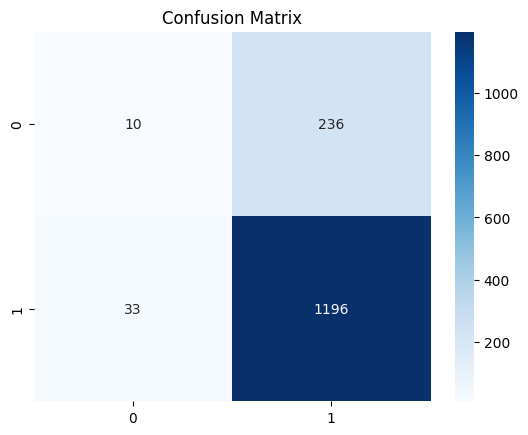

In [ ]:
# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(x_train, y_train)
print("XGBoost Results:")
evaluate_model(xgb, x_test, y_test)


CatBoost Results:
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       246
           1       0.83      1.00      0.91      1229

    accuracy                           0.83      1475
   macro avg       0.42      0.50      0.45      1475
weighted avg       0.69      0.83      0.76      1475

Accuracy Score: 0.8311864406779661


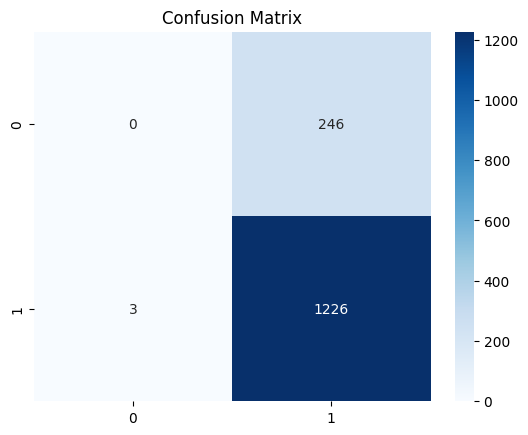

In [ ]:
# CatBoost
catboost = CatBoostClassifier(verbose=0, random_state=42)
catboost.fit(x_train, y_train)
print("CatBoost Results:")
evaluate_model(catboost, x_test, y_test)

[LightGBM] [Info] Number of positive: 3684, number of negative: 739
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1447
[LightGBM] [Info] Number of data points in the train set: 4423, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.832919 -> initscore=1.606456
[LightGBM] [Info] Start training from score 1.606456
LightGBM Results:
Classification Report:
               precision    recall  f1-score   support

           0       0.08      0.00      0.01       246
           1       0.83      0.99      0.90      1229

    accuracy                           0.83      1475
   macro avg       0.46      0.50      0.46      1475
weighted avg       0.71      0.83      0.76      1475

Accuracy Score: 0.8264406779661017


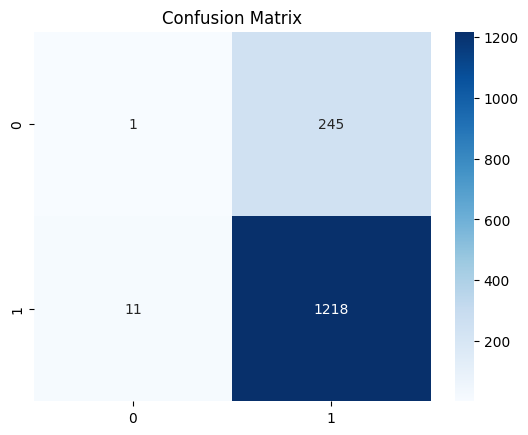

In [ ]:
# LightGBM
lgbm = LGBMClassifier(random_state=42)
lgbm.fit(x_train, y_train)
print("LightGBM Results:")
evaluate_model(lgbm, x_test, y_test)

[LightGBM] [Info] Number of positive: 3684, number of negative: 739
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1447
[LightGBM] [Info] Number of data points in the train set: 4423, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.832919 -> initscore=1.606456
[LightGBM] [Info] Start training from score 1.606456
[LightGBM] [Info] Number of positive: 2947, number of negative: 591
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1441
[LightGBM] [Info] Number of data points in the train set: 3538, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.832956 -> initscore=1.606727
[LightGBM] [I

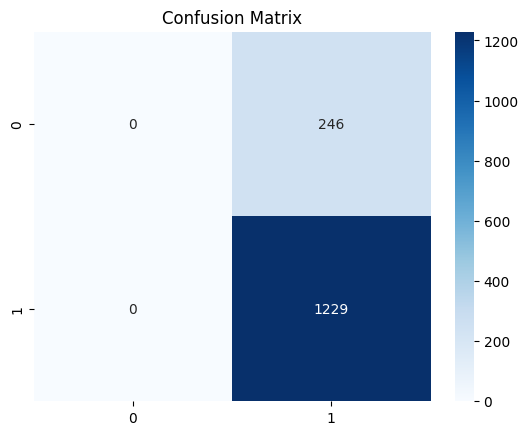

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Define base models
base_models = [
    ('xgb', XGBClassifier(random_state=42)),
    ('catboost', CatBoostClassifier(verbose=0, random_state=42)),
    ('lgbm', LGBMClassifier(random_state=42))
]

# Meta-model (Logistic Regression)
stacked_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression(), cv=5)
stacked_model.fit(x_train, y_train)
y_pred = stacked_model.predict(x_test)
print("Stacking Model Results:")
evaluate_model(stacked_model, x_test, y_test)


In [ ]:
# Hyperparameter Tuning Example for LightGBM
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [5, 10, 20],
    'num_leaves': [31, 50, 100]
}
grid_lgbm = GridSearchCV(LGBMClassifier(random_state=42), param_grid, cv=3, scoring='accuracy', verbose=1)
grid_lgbm.fit(x_train, y_train)
print("Best Parameters for LightGBM:", grid_lgbm.best_params_)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000608 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1436
[LightGBM] [Info] Number of data points in the train set: 2949, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.832825 -> initscore=1.605780
[LightGBM] [Info] Start training from score 1.605780
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

In [ ]:
# Final Model Training on Best Model (using Optuna's best parameters)
best_xgb = XGBClassifier(**study.best_params, random_state=42)
best_xgb.fit(X_scaled, y)

# Make predictions
test_predictions = best_xgb.predict(test_scaled)


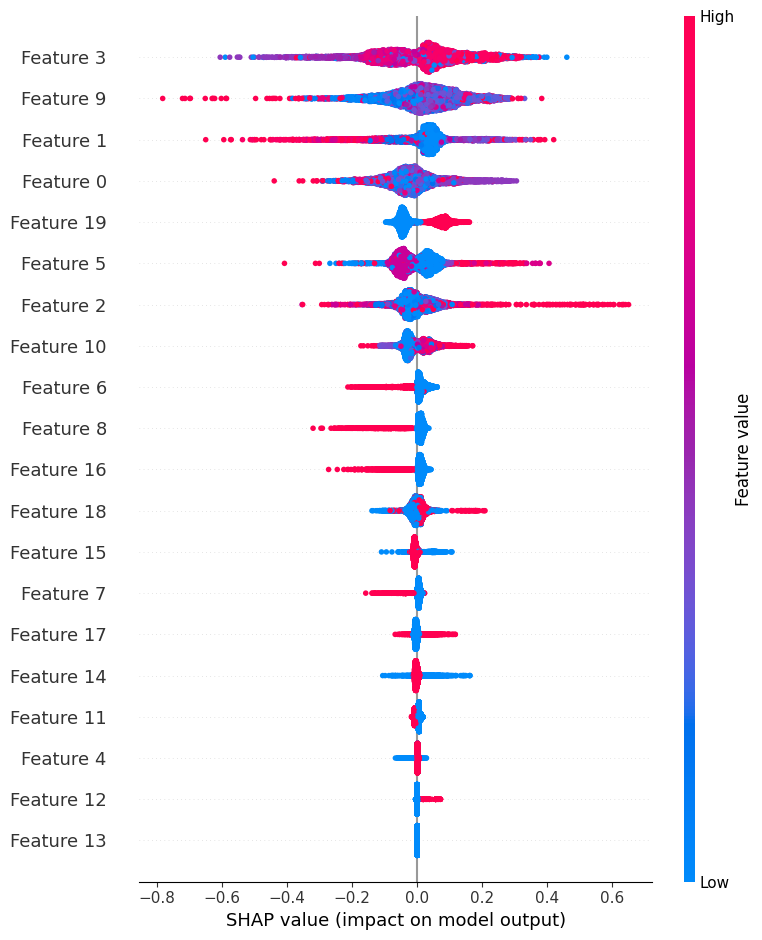

In [ ]:
import shap

explainer = shap.Explainer(best_xgb)
shap_values = explainer(X_scaled)
shap.summary_plot(shap_values, X_scaled)


In [ ]:
# Save Submission
sample_sub['Loan_Status'] = test_predictions
sample_sub.to_csv('optimized_submission_advanced.csv', index=False)

In [ ]:
from google.colab import files

# Download the file, use the correct filename
files.download('optimized_submission_advanced.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>